In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r /content/drive/MyDrive/FACT/requirements.txt
%pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## 1. Building Dataset

In [ ]:
import random
import pickle
import string
from itertools import product
from functools import partial
import time
import numpy as np
import matplotlib.pyplot as plt

import torch

from transformer_lens import HookedTransformer
from transformer_lens import utils, patching

from IPython.display import clear_output


!cp /content/drive/MyDrive/FACT/plotly_utils.py ./custom_plotly_utils.py
#import plotly_utils as pu
from custom_plotly_utils import imshow, line, scatter

data_path = "/content/drive/MyDrive/FACT/data/"
start_time = time.time()


%load_ext autoreload
%autoreload 2

### New dataset
1. Take list of all 3-letter acronyms that are tokenized as three separate tokens (e.g. "|A|B|C|")
2. Take list of words that are tokenized as a single token (including their preceding space, e.g. "| Bruh|")
3. Create list of samples by (i) choosing and acronym and (ii) sampling a word from the previous list for every capital letter of the acronym (e.g. "|The| Auto| Bruh| Cafe|(|A|B|C|"). **NOTE:** We will sample the acronyms according to the frequency of the capital letters on our dictionary. We do this because, for example, there are a lot of acronyms containing the letter X but we have just one word beginning by X on our dictionary (as these are uncommon) thus uniformly sampling the acronyms would bring the word X a lot more than usual.

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
acronyms_list = list(product(string.ascii_uppercase, repeat=3))
acronyms_list = ["".join(x) for x in acronyms_list]
len(acronyms_list)

17576

In [ ]:
acronyms_tokenized = model.to_tokens(acronyms_list, prepend_bos=False)
# Take the indices of acronyms that are composed by 3 tokens, i.e. its last token is different from the BOS token
indices = torch.arange(acronyms_tokenized.shape[0], device="cuda")[acronyms_tokenized[:, -1] != 50256]
indices.shape

torch.Size([2740])

In [ ]:
possible_acronyms_list = model.to_string(acronyms_tokenized[indices])
len(possible_acronyms_list), possible_acronyms_list[:5]

(2740, ['AJE', 'AJF', 'AJG', 'AJH', 'AJI'])

There are 2740 3-letter acronyms that are tokenized as three separate words.

Now, let's collect a set of nouns that are tokenized as single tokens.

We will take the words from https://github.com/taikuukaits/SimpleWordlists/tree/master (Ashley Bovan page). It contains around **91k** nouns, so it should be sufficient (some of them are quite rare):

In [ ]:
with open(f"{data_path}/nouns_1_token.txt", "w") as g:
    with open(f"{data_path}/Wordlist-Nouns-All.txt", "r") as f:
        for word in f.read().splitlines():
            word = " " + word.capitalize()
            str_word = model.to_str_tokens(word, prepend_bos=False)
            if len(str_word) == 1:
                g.write(word + "\n")

In [ ]:
with open(f"{data_path}/nouns_1_token.txt", "r") as f:
    print(len(f.read().splitlines()))

6997


When filtering the nouns that are not tokenized as single tokens (including a preceding space) we drop from 91k to 7k. Now, to make it easier, we will build a dictionary that groups words beginning with the same capital letter:

In [ ]:
# Initialize dictionary
words_dict = {}
for c in string.ascii_uppercase:
    words_dict[c] = []

n_words = 0
with open(f"{data_path}/nouns_1_token.txt", "r") as f:
    for word in f.read().splitlines():
        words_dict[word[1]].append(word)
        n_words += 1

with open(f"{data_path}/words_dict.pkl", "wb") as f:
    pickle.dump(words_dict, f)

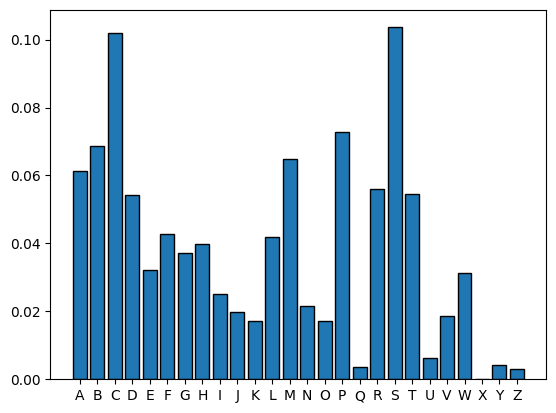

In [ ]:
with open(f"{data_path}/words_dict.pkl", 'rb') as f:
        words_dict = pickle.load(f)

prob_dict = {}

n_words = sum([len(v) for _, v in words_dict.items()])

# get the probability of sampling a word beginning by each letter
for k, v in words_dict.items():
    prob_dict[k] = float(len(v)) / n_words

plt.bar(x=prob_dict.keys(), height=prob_dict.values(), edgecolor="black");

In [ ]:
# probability distribution of the acronym list
p = np.array([prob_dict[acronym[0]]*prob_dict[acronym[1]]*prob_dict[acronym[2]] for acronym in possible_acronyms_list])
# normalize
p = p / p.sum()

In [ ]:
def get_random_acronym(acronyms_list=possible_acronyms_list, words_dict_path=f"{data_path}/words_dict.pkl"):

    with open(words_dict_path, 'rb') as f:
        words_dict = pickle.load(f)

    acronym = np.random.choice(acronyms_list, size=1, p=p)[0]
    prompt = "The"
    for c in acronym:
        # Obtain a random word that meets the requirements
        word = random.choice(words_dict[c])
        prompt += word
    prompt = prompt + " (" + acronym[:2]
    return prompt, acronym

prompt, acronym = get_random_acronym()
prompt, model.to_string(model(prompt)[:, -1].argmax(-1))

('The Overall Identity Warden (OI', 'W')

Now that we have defined the sampling method, we will retrieve a list of 100000 samples.

In [ ]:
i = 0
with open(f"{data_path}/acronyms.txt", "w") as f:
    while i < 10000:
        prompt, acronym = get_random_acronym()
        f.write(prompt + ", " + acronym + "\n")
        i += 1

## 2. Localizing the underlying circuit via activation patching

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def compute_logit_diff_2(logits, answer_tokens, average=True):
    """
    Compute the logit difference between the correct answer and the largest logit
    of all the possible incorrect capital letters. This is done for every iteration
    (i.e. each of the three letters of the acronym) and then averaged if desired.
    If `average=False`, then a `Tensor[batch_size, 3]` is returned, containing the
    logit difference at every iteration for every prompt in the batch

    Parameters:
    -----------
    - `logits`: `Tensor[batch_size, seq_len, d_vocab]`
    - `answer_tokens`: Tensor[batch_size, 3]
    """
    # Logits of the correct answers (batch_size, 3)
    correct_logits = logits[:, -3:].gather(-1, answer_tokens[..., None]).squeeze()
    # Retrieve the maximum logit of the possible incorrect answers
    capital_letters_tokens = torch.tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57], dtype=torch.long, device=device)
    batch_size = logits.shape[0]
    capital_letters_tokens_expanded = capital_letters_tokens.expand(batch_size, 3, -1)
    incorrect_capital_letters = capital_letters_tokens_expanded[capital_letters_tokens_expanded != answer_tokens[..., None]].reshape(batch_size, 3, -1)
    incorrect_logits, _ = logits[:, -3:].gather(-1, incorrect_capital_letters).max(-1)
    # Return the mean
    return (correct_logits - incorrect_logits).mean() if average else (correct_logits - incorrect_logits)

def topk_of_Nd_tensor(tensor, k):
    '''
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    '''
    i = torch.topk(tensor.flatten(), k).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
with open(f"{data_path}/acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

# take a subset of the dataset (we do this because VRAM limitations)
# you can take as much as your GPU can
n_samples = 50 # originally 250
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

In [ ]:
clean_tokens = model.to_tokens(prompts)
answer_tokens = model.to_tokens(acronyms, prepend_bos=False)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logits = model(clean_tokens)

In [ ]:
clean_logit_diff = compute_logit_diff_2(clean_logits, answer_tokens, average=True)
clean_logit_diff.item()

1.7001745700836182

In [ ]:
corrupted_tokens = clean_tokens.clone()
corrupted_tokens = corrupted_tokens[torch.randperm(corrupted_tokens.shape[0])]

corrupted_tokens_acronym = clean_tokens.clone()
corrupted_tokens_acronym = corrupted_tokens_acronym[torch.randperm(corrupted_tokens_acronym.shape[0])]

corrupted_tokens[:, -2:] = corrupted_tokens_acronym[:, -2:]

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

In [ ]:
compute_logit_diff_2(corrupted_logits, answer_tokens).item()

-2.4275996685028076

In [ ]:
act_patch_resid_pre_iter = []
indices = [2, 3, 4]
for i, j in enumerate(indices):
    # Corrupt just the current word
    corrupted_tokens_i = clean_tokens.clone()
    corrupted_tokens_i[:, j:j+2] = corrupted_tokens[:, j:j+2]
    _, corrupted_cache_i = model.run_with_cache(corrupted_tokens_i)

    compute_logit_diff_aux = partial(compute_logit_diff_2, answer_tokens=answer_tokens, average=False) # returns (batch_size, 3)
    compute_logit_diff_iter = lambda logits: compute_logit_diff_aux(logits)[:, i].mean()
    act_patch_resid_pre = patching.get_act_patch_resid_pre(model, clean_tokens, corrupted_cache_i, compute_logit_diff_iter)
    act_patch_resid_pre_iter.append(act_patch_resid_pre)
act_patch_resid_pre_iter = torch.stack(act_patch_resid_pre_iter, dim=0)

clear_output()

In [ ]:
facet_labels = ["Iteration 0", "Iteration 1", "Iteration 2"]
labels = ["BOS", "The", "C1", "C2", "C3", " (", "A1", "A2"]

baseline_logit_diff = compute_logit_diff_2(clean_logits, answer_tokens, average=False).mean(0)

imshow(
    act_patch_resid_pre_iter - baseline_logit_diff[..., None, None],
    x=labels,
    facet_col=0, # This argument tells plotly which dimension to split into separate plots
    facet_col_wrap=3,
    facet_labels=facet_labels, # Subtitles of separate plots
    title="Residual Stream Patching",
    labels={"x": "Sequence Position", "y": "Layer"},
    height=400,
    width=1000,
)

In [ ]:
act_patch_attn_head_out_all_pos_iter = []
indices = [2, 3, 4]
for i, j in enumerate(indices):
    # Corrupt just the current word
    corrupted_tokens_i = clean_tokens.clone()
    corrupted_tokens_i[:, j:j+2] = corrupted_tokens[:, j:j+2]
    _, corrupted_cache_i = model.run_with_cache(corrupted_tokens_i)

    compute_logit_diff_aux = partial(compute_logit_diff_2, answer_tokens=answer_tokens, average=False) # returns (batch_size, 3)
    compute_logit_diff_iter = lambda logits: compute_logit_diff_aux(logits)[:, i].mean()
    act_patch_attn_head_out_all_pos = patching.get_act_patch_attn_head_out_all_pos(model, clean_tokens, corrupted_cache_i, compute_logit_diff_iter)
    act_patch_attn_head_out_all_pos_iter.append(act_patch_attn_head_out_all_pos)
act_patch_attn_head_out_all_pos_iter = torch.stack(act_patch_attn_head_out_all_pos_iter, dim=0)

clear_output()

In [ ]:
facet_labels = ["Iteration 0", "Iteration 1", "Iteration 2"]
labels = ["BOS", "The", "C1", "C2", "C3", " (", "A1", "A2"]

baseline_logit_diff = compute_logit_diff_2(clean_logits, answer_tokens, average=False).mean(0)

fig = imshow(
    (act_patch_attn_head_out_all_pos_iter - baseline_logit_diff[..., None, None])[2],
    #facet_col=0,
    #facet_labels=facet_labels,
    labels={"y": "Layer", "x": "Head"},
    #title="Patching Attention Heads",
    width=400, height=400,
    return_fig=True
)
fig.write_image("/content/drive/MyDrive/FACT/activations.svg")

In [ ]:
k = 5
path_patch_head_to_heads_iteration = act_patch_attn_head_out_all_pos_iter - baseline_logit_diff[..., None, None]
top_heads_1 = topk_of_Nd_tensor(-1*path_patch_head_to_heads_iteration[0], k)
top_heads_2 = topk_of_Nd_tensor(-1*path_patch_head_to_heads_iteration[1], k)
top_heads_3 = topk_of_Nd_tensor(-1*path_patch_head_to_heads_iteration[2], k)

print(f"Top {k} heads on iteration 1: {top_heads_1}")
print(f"Top {k} heads on iteration 2: {top_heads_2}")
print(f"Top {k} heads on iteration 3: {top_heads_3}")

Top 5 heads on iteration 1: [[10, 10], [8, 11], [9, 9], [4, 7], [0, 5]]
Top 5 heads on iteration 2: [[10, 10], [8, 11], [0, 1], [4, 7], [8, 10]]
Top 5 heads on iteration 3: [[10, 10], [8, 11], [9, 9], [7, 10], [8, 3]]


## 3. Building Acronyms

In [ ]:
from string import ascii_uppercase
from tqdm import tqdm
import random
import pickle

import pandas as pd
import matplotlib.pyplot as plt

import torch

from sentence_transformers.util import semantic_search, dot_score, normalize_embeddings
from transformer_lens import HookedTransformer

torch.manual_seed(42);

**What are we trying to do?:** Automatically generating adversarial samples to detect and understand possible vulnerabilities on circuits associated to specific tasks. In this case, we are studying the task of three-letter acronym prediction. First, we will try to generate samples that are **incorrectly predicted by the model**, i.e. certain samples or letters that are incorrectly predicted, hence detecting possible vulnerabilities.

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
# tokens of capital letters
cap_tokens = model.to_tokens([x for x in ascii_uppercase], prepend_bos=False)[:, 0]
cap_tokens_space = model.to_tokens([" " + str(x) for x in ascii_uppercase], prepend_bos=False)[:, 0]
# as we are taking a subset of the vocabulary, we also enumerate them in order
# (e.g 'A' is the token 32, but is enumerated as 0 on the subspace, etc.)
idx_to_token = {k:v.item() for k, v in enumerate(cap_tokens)}
token_to_idx = {v.item():k for k, v in enumerate(cap_tokens)}
space_to_no_space = {k.item():v.item() for k,v in zip(cap_tokens_space, cap_tokens)}
no_space_to_space = {k.item():v.item() for k,v in zip(cap_tokens, cap_tokens_space)}

In [ ]:
# indices of the token containing the first/second/third capital letters
indices_letters = [2, 3, 4]
# same for the acronym letter -1 (this is where the corresponding logit is stored)
indices_logits = [5, 6, 7]
# letter that we want to modify: 0, 1 or 2
letter = 2

In [ ]:
with open(f"{data_path}/acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = 1000
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

tokens = model.to_tokens(prompts)
# ground truth: third letter of the acronym (tokens)
y = model.to_tokens([x[letter] for x in acronyms], prepend_bos=False).squeeze()
with torch.no_grad():
    y_pred = model(tokens)[:, indices_logits[letter]].argmax(dim=-1)
# discard already misclassified samples
tokens = tokens[y_pred == y]
y = y[y_pred == y]
# reupdate n_samples
n_samples = tokens.shape[0]

y_idx = y.cpu().apply_(token_to_idx.get).cuda()

In [ ]:
batch_size = 128

# randomly sample batch_size initial samples
idx = torch.randint(0, n_samples, (batch_size,))
sample_tokens = tokens[idx]
sample_y = y[idx]
sample_y_idx = y_idx[idx]
sample_embeddings = model.W_E[sample_tokens].clone().detach()
sample_embeddings.requires_grad = True

sample_tokens.shape, sample_embeddings.shape, sample_y.shape, sample_y_idx.shape

(torch.Size([128, 8]),
 torch.Size([128, 8, 768]),
 torch.Size([128]),
 torch.Size([128]))

In [ ]:
def project_embeddings(sample_embeddings, embedding_matrix, vocab, mask):
    """
    Given a batch of sample adversarial embeddings, project
    them into their closest token in the embedding space.

    Input:
    - `sample_embeddings`: Tensor of shape (batch_size, seq_len, d_model)
    - `embedding_matrix`: Tensor of shape (d_vocab, d_model)
    - `vocab`: Tensor of shape (n_vocab,), where n_vocab <= d_vocab, containing
        the list of possible tokens when projecting/updating the samples. The reason
        for this is that, for example, when generating acronyms, we might not want to
        change a capital letter to a non-capital letter, i.e. we want to stay inside a
        concrete vocabulary.
    - `mask`: Tensor of shape (seq_len,). mask[i] = 1 means that the i-th token will be
    optimized/changed by the algorithm.

    Returns:

    Two tensors containing both the ids and the embedding vectors of the projected vectors.
    - `projected_tokens`: Tensor of shape (batch_size, seq_len)
    - `projected_embeddings`: Tensor of shape (batch_size, seq_len, d_model)
    """
    vocab_embedding_matrix = normalize_embeddings(embedding_matrix[vocab])
    # project the sample embeddings, i.e. find the closest embedding pertaining to a real token
    result = semantic_search(normalize_embeddings(sample_embeddings.view(-1, sample_embeddings.shape[-1])), # flatten the batch size and pos dimensions and normalize
                vocab_embedding_matrix,
                query_chunk_size=sample_embeddings.shape[0], top_k=1,
                score_function=dot_score)
    projected_tokens = torch.tensor([vocab[x[0]["corpus_id"]] for x in result]).cuda()
    projected_tokens = projected_tokens.view(sample_embeddings.shape[:-1]) # (batch_size, seq_len)
    projected_tokens = torch.where(mask, projected_tokens, sample_tokens) # project only the tokens specified by the mask
    projected_embeddings = embedding_matrix[projected_tokens].clone().detach()
    return projected_tokens, projected_embeddings

embedding_matrix = model.W_E
# now the vocabulary of optimization is every single token word possible
with open(f"{data_path}/words_dict.pkl", 'rb') as f:
    words_dict = pickle.load(f)
word_list = [v for _, v in words_dict.items()]
word_list = [x for xs in word_list for x in xs]
vocab = model.to_tokens(word_list, prepend_bos=False)[:, 0]

mask = torch.zeros(sample_tokens.shape[-1], dtype=torch.bool).cuda()
mask[indices_letters[letter]] = 1

projected_tokens, projected_embeddings = project_embeddings(sample_embeddings, embedding_matrix, vocab, mask)
torch.equal(projected_tokens, sample_tokens), torch.equal(projected_embeddings, sample_embeddings)

(True, True)

In [ ]:
def AdvMarginLoss(margin=1.0):
    """
    Create the adversarial Margin Loss
    """
    def loss_fn(logits, y, average=True):
        """
        Return the adversarial margin loss used to generate adversarial samples.

        Parameters:
        - `logits`: Tensor of shape (batch_size, num_classes) containing the logits.
        - `y`: Tensor of shape (batch_size,) containing the index of the ground truth.
        """
        # gather the logits of the ground truth
        logits_correct = logits[torch.arange(0, logits.shape[0]), y] # (batch_size,)
        # retrieve the maximum logits of the incorrect answers
        y_incorrect = torch.ones_like(logits, dtype=bool)
        y_incorrect[torch.arange(0, logits.shape[0]), y] = 0
        max_logits_incorrect = logits[y_incorrect].view(logits.shape[0], -1).max(1).values # (batch_size,)
        loss = (logits_correct - max_logits_incorrect + margin)
        loss = torch.where(loss < 0, torch.zeros_like(loss), loss)

        return loss.mean() if average else loss

    return loss_fn

100%|██████████| 200/200 [01:28<00:00,  2.27it/s]


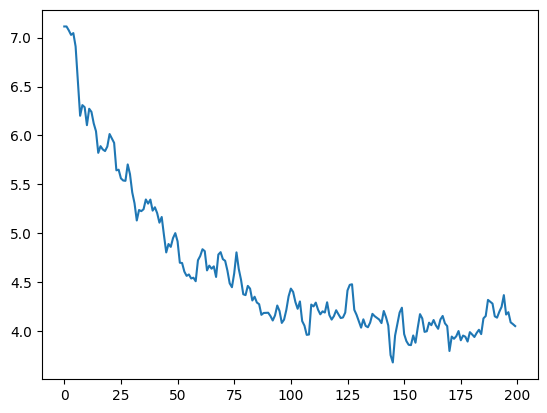

In [ ]:
# First test: start with an initial sample, modify just the third capital letter to minimize the adversarial loss, i.e.
# use our algorithm to automatically generate samples that incorrectly predict the third letter, DESPITE being valid sentences!

batch_size = 128

# randomly sample batch_size initial samples
idx = torch.randint(0, n_samples, (batch_size,))
sample_tokens = tokens[idx]
sample_y = y[idx]
sample_y_idx = y_idx[idx]
sample_embeddings = model.W_E[sample_tokens].clone().detach()
sample_embeddings.requires_grad = True

embedding_matrix = model.W_E

# now the vocabulary of optimization is every single token word possible
with open(f"{data_path}/words_dict.pkl", 'rb') as f:
    words_dict = pickle.load(f)
word_list = [v for _, v in words_dict.items()]
word_list = [x for xs in word_list for x in xs]
vocab = model.to_tokens(word_list, prepend_bos=False)[:, 0]

mask = torch.zeros(sample_tokens.shape[-1], dtype=torch.bool).cuda()
mask[indices_letters[letter]] = 1

lr=1e-1
weight_decay=1e-1
margin = 4
loss_fn = AdvMarginLoss(margin=margin)

input_optimizer = torch.optim.AdamW([sample_embeddings], lr=lr, weight_decay=weight_decay)

# we will collect the adversarial samples: samples that are incorrectly classified by the model
adv_samples = []
# we also collect the original sample associated to each adversarial sample
original_samples = []
losses = []
# OPTIMIZE
for _ in tqdm(range(200), disable=False):

    # Project the embeddings
    projected_tokens, projected_embeddings = project_embeddings(sample_embeddings, embedding_matrix, vocab, mask)
    # BRUH this is causing a high bottleneck. Optimize when everything works right
    sample_y_idx = torch.tensor([token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()] for x in projected_tokens], dtype=torch.long).cuda()

    tmp_embeddings = sample_embeddings.detach().clone()
    tmp_embeddings.data = projected_embeddings.data
    tmp_embeddings.requires_grad = True

    # Take the logits of the subspace
    logits_vocab = model.forward(tmp_embeddings + model.pos_embed(projected_tokens), start_at_layer=0)[:, indices_logits[letter], cap_tokens]

    loss = loss_fn(logits_vocab, sample_y_idx, average=True)

    sample_embeddings.grad, = torch.autograd.grad(loss, [tmp_embeddings])
    # set the gradient of elements outside the mask to zero
    sample_embeddings.grad = torch.where(mask[None, ..., None], sample_embeddings.grad, 0.)
    input_optimizer.step()
    input_optimizer.zero_grad()
    #print(loss.item())
    #print(model.to_string(projected_tokens))
    losses.append(loss.item())

    with torch.no_grad():
        # Re-project the embeddings
        projected_tokens, projected_embeddings = project_embeddings(sample_embeddings, embedding_matrix, vocab, mask)
        sample_y_idx = torch.tensor([token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()] for x in projected_tokens], dtype=torch.long).cuda()
        # check if there are adversarial samples
        # Take the logits of the subspace
        logits_vocab = model.forward(projected_embeddings + model.pos_embed(projected_tokens), start_at_layer=0)[:, indices_logits[letter], cap_tokens]

        loss_i = loss_fn(logits_vocab, sample_y_idx, average=False)
        adv_samples.append(projected_tokens[loss_i < margin]) # a loss lower than margin implies that the sample is incorrectly classified
        original_samples.append(sample_tokens[loss_i < margin])

adv_samples = torch.cat(adv_samples, dim=0)
original_samples = torch.cat(original_samples, dim=0)
adv_samples, inverse_indices = torch.unique(adv_samples, sorted=False, dim=0, return_inverse=True)
original_samples_unique = torch.zeros_like(adv_samples)
original_samples_unique[inverse_indices] = original_samples[torch.arange(0, original_samples.shape[0])]
original_samples = original_samples_unique
plt.plot(losses)

In [ ]:
adv_samples.shape[0]

419

In [ ]:
model.cpu()
adv_token_preds = model(adv_samples)[:, indices_logits[letter], cap_tokens.cpu()].argmax(-1).cpu().apply_(idx_to_token.get)
original_token_preds = model(original_samples)[:, indices_logits[letter], cap_tokens.cpu()].argmax(-1).cpu().apply_(idx_to_token.get)


for a, b, c, d in zip(model.to_string(adv_samples[:, :indices_logits[letter]+1]), model.to_string(adv_token_preds), model.to_string(original_samples[:, :indices_logits[letter]+1]), model.to_string(original_token_preds)):
    print(c, "->",d)
    print(a, "->",b)
    print("-"*40)

Moving model to device:  cpu
<|endoftext|>The King Horses Zion (KH -> Z
<|endoftext|>The King Horses Lucas (KH -> J
----------------------------------------
<|endoftext|>The King Horses Zion (KH -> Z
<|endoftext|>The King Horses Ellen (KH -> X
----------------------------------------
<|endoftext|>The King Horses Zion (KH -> Z
<|endoftext|>The King Horses Reggie (KH -> J
----------------------------------------
<|endoftext|>The King Horses Zion (KH -> Z
<|endoftext|>The King Horses Cindy (KH -> J
----------------------------------------
<|endoftext|>The King Horses Zion (KH -> Z
<|endoftext|>The King Horses Alicia (KH -> X
----------------------------------------
<|endoftext|>The King Horses Zion (KH -> Z
<|endoftext|>The King Horses Stella (KH -> X
----------------------------------------
<|endoftext|>The January Hob Winnipeg (JH -> W
<|endoftext|>The January Hob Billy (JH -> J
----------------------------------------
<|endoftext|>The Wed Yak Fiesta (WY -> F
<|endoftext|>The Wed Yak Mi

In [ ]:
unique_tokens, count = torch.unique(torch.tensor([model.to_tokens(model.to_string(x)[1], prepend_bos=False).item() for x in adv_samples[:, indices_letters[letter]]], dtype=torch.long), return_counts=True)
unique_caps = model.to_string(unique_tokens)

adv_freq_dict = {}
for c in ascii_uppercase:
    adv_freq_dict[c] = 0

A = []
B = []
for a, b in zip(unique_caps, count):
    adv_freq_dict[a] = b.item()

In [ ]:
# save the adversarial samples (note that we discard those whose acronyms are not properly tokenized as 3 tokens!)
with open(f"{data_path}/{letter}_adv_acronyms.txt", "a") as f:
    for sentence in model.to_string(adv_samples[:, 1:]):
        acronym = (''.join([c for c in sentence if c.isupper()]))[1:-2]
        if model.to_tokens(acronym, prepend_bos=False).shape[1] == 3:
            f.write(sentence + ", " + acronym + "\n")

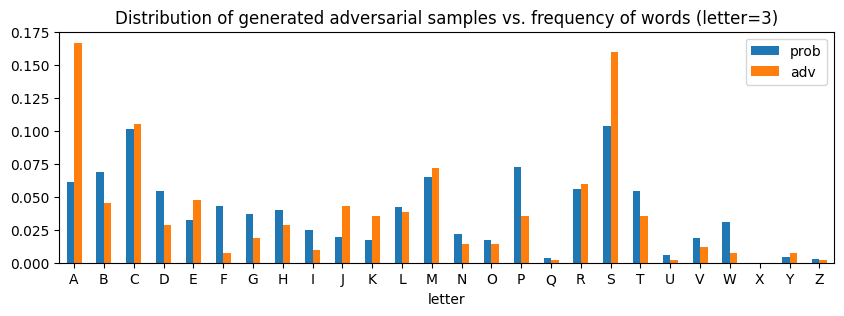

In [ ]:
with open(f"{data_path}/words_dict.pkl", 'rb') as f:
        words_dict = pickle.load(f)

prob_dict = {}

n_words = sum([len(v) for _, v in words_dict.items()])

# get the probability of sampling a word beginning by each letter
for k, v in words_dict.items():
    prob_dict[k] = float(len(v)) / n_words

df = pd.DataFrame({"letter": list(ascii_uppercase), "prob": list(prob_dict.values()), "adv": list(adv_freq_dict.values())})
df["adv"] = df["adv"] / df["adv"].sum()
df.plot.bar(x="letter", rot=0, figsize=(10, 3), title=f"Distribution of generated adversarial samples vs. frequency of words (letter={letter+1})");

In [ ]:
letter_counts = {letter: 0 for letter in ascii_uppercase}

with open(f"{data_path}/acronyms.txt", 'r') as f:
    for line in f:
        if line.strip():  # Skip empty lines
            last_letter = line.strip()[-1]
            letter_counts[last_letter] += 1
total = sum(letter_counts.values())
probabilities = {k: v/total for k, v in letter_counts.items()}

df['probability'] = [probabilities[letter] for letter in ascii_uppercase]

# acr = [a[2] for a in acronyms]
# letter_counts = {letter: 0 for letter in ascii_uppercase}
# for l in acr:
#   letter_counts[l] += 1
# total = sum(letter_counts.values())
# probabilities = {k: v/total for k, v in letter_counts.items()}
# df['probability'] = [probabilities[letter] for letter in ascii_uppercase]

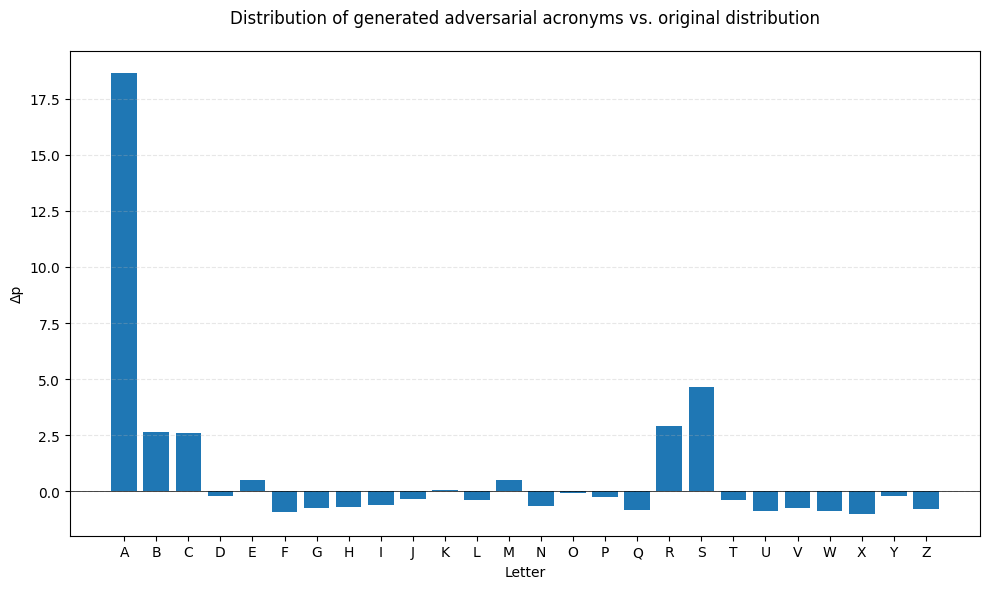

In [ ]:
df['delta_p'] = (df['adv'] - df['probability']) / df['probability']

plt.figure(figsize=(10, 6))
bars = plt.bar(df['letter'], df['delta_p'])
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.title('Distribution of generated adversarial acronyms vs. original distribution', pad=20)
plt.xlabel('Letter')
plt.ylabel('Δp')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/FACT/delta_p.svg")
plt.show()


## Locating vulnerabilities

Now we have a set of misclassified adversarial samples: how can we locate which components are affected?

One idea is to analyze the logit attribution to the correct answer: is a component contributes negatively to the correct answer on the adversarial sample, it means that the vulnerability must be close.

In essence, we have to:

1. Obtain the contributions of each head to the residual stream.
2. Unembed them to obtain the logits.
3. Compute the logit difference.

In [ ]:
import random
from functools import partial
from IPython.display import clear_output
from string import ascii_uppercase

import numpy as np
import einops

import torch

from transformer_lens import HookedTransformer
from transformer_lens import utils, patching

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def topk_of_Nd_tensor(tensor, k):
    '''
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    '''
    i = torch.topk(tensor.flatten(), k).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()

def get_logit_diff_directions(answer_tokens, pred_answer_tokens):
    """
    Obtains the direction of the logit difference, i.e. it takes the
    vector of the correct answer and the vector of the incorrect answer
    with the maximum logit in the embedding space and returns the difference.
    This allows us to compute the logit attribution of any residual vector by
    performing a simple dot product (more efficient than the previous approach)

    Parameters:
    -----------
    - `answer_tokens`: Tensor of shape (batch_size, 3) containing the correct tokens.
    - `pred_answer_tokens`: Tensor of shape (batch_size, 3) containing the most likely incorrect tokens.

    Returns:
    --------
    - `logit_diff_directions`: Tensor of shape (batch_size, 3, d_model) containining the directions of the logit difference.
    """
    # pre-compute the directions of each capital letter on the residual space
    capital_letters_tokens = torch.tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
            50, 51, 52, 53, 54, 55, 56, 57], dtype=torch.long, device=device)
    capital_letter_directions = model.tokens_to_residual_directions(capital_letters_tokens) # (n_letters, d_model)
    capital_letters_tokens_expanded = capital_letters_tokens.expand(answer_tokens.shape[0], 3, -1) # (batch_size, 3, n_letters)
    capital_letter_directions_expanded = capital_letter_directions.expand(answer_tokens.shape[0], 3, -1, model.cfg.d_model) # (batch_size, 3, n_letters, d_model)
    max_incorrect_directions = capital_letter_directions_expanded[capital_letters_tokens_expanded == pred_answer_tokens[..., None]].reshape(answer_tokens.shape[0], -1, model.cfg.d_model) # (batch_size, 3, d_model)
    correct_directions   = capital_letter_directions_expanded[capital_letters_tokens_expanded == answer_tokens[..., None]].reshape(answer_tokens.shape[0], -1, model.cfg.d_model) # (batch_size, 3, d_model)
    logit_diff_directions = correct_directions - max_incorrect_directions # (batch_size, 3, d_model)

    return logit_diff_directions

In [ ]:
def residual_stack_to_logit_diff(residual_stack, cache, logit_diff_directions):
    '''
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    '''
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return einops.einsum(
        scaled_residual_stack, logit_diff_directions,
        "... batch d_model, batch d_model -> ... batch"
    )

In [ ]:
# tokens of capital letters
cap_tokens = model.to_tokens([x for x in ascii_uppercase], prepend_bos=False)[:, 0]
cap_tokens_space = model.to_tokens([" " + str(x) for x in ascii_uppercase], prepend_bos=False)[:, 0]
# as we are taking a subset of the vocabulary, we also enumerate them in order
# (e.g 'A' is the token 32, but is enumerated as 0 on the subspace, etc.)
idx_to_token = {k:v.item() for k, v in enumerate(cap_tokens)}
token_to_idx = {v.item():k for k, v in enumerate(cap_tokens)}
space_to_no_space = {k.item():v.item() for k,v in zip(cap_tokens_space, cap_tokens)}
no_space_to_space = {k.item():v.item() for k,v in zip(cap_tokens, cap_tokens_space)}


# indices of the token containing the first/second/third capital letters
indices_letters = [2, 3, 4]
# same for the acronym letter -1 (this is where the corresponding logit is stored)
indices_logits = [5, 6, 7]
# letter that we want to modify: 0, 1 or 2
letter = 2

In [ ]:
with open(f"{data_path}/2_adv_acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

adv_letter = "A"

prompts = [prompt for prompt in prompts if adv_letter == model.to_str_tokens(prompt)[indices_letters[letter]][1]]

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = len(prompts)
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

In [ ]:
tokens = model.to_tokens(prompts)
answer_tokens = model.to_tokens(acronyms, prepend_bos=False)

logits, cache = model.run_with_cache(tokens)
logits = model(tokens)

# Logits of the correct answers (batch_size, 3)
correct_logits = logits[:, -3:].gather(-1, answer_tokens[..., None]).squeeze()
# Retrieve the maximum logit of the possible incorrect answers
capital_letters_tokens = torch.tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57], dtype=torch.long, device=device)
batch_size = logits.shape[0]
capital_letters_tokens_expanded = capital_letters_tokens.expand(batch_size, 3, -1)
incorrect_capital_letters = capital_letters_tokens_expanded[capital_letters_tokens_expanded != answer_tokens[..., None]].reshape(batch_size, 3, -1)
pred_answer_tokens = logits[:, -3:].gather(-1, incorrect_capital_letters).argmax(-1).cpu().apply_(idx_to_token.get).cuda()

In [ ]:
logit_diff_directions = get_logit_diff_directions(answer_tokens, pred_answer_tokens)[:, letter] # (batch_size, 3, d_model)

per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(
    per_head_residual,
    "(layer head) ... -> layer head ...",
    layer=model.cfg.n_layers
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_directions).mean(-1)

fig = imshow(
    per_head_logit_diffs,
    labels={"x":"Head", "y":"Layer"},
    #title="Logit Difference From Each Head",
    width=400, height=400,
    return_fig=True
)
fig.write_image("/content/drive/MyDrive/FACT/logitdiff.svg")

## Interpret Vulnerabilities

In [ ]:
import random
from functools import partial
from IPython.display import clear_output
from string import ascii_uppercase

import numpy as np
import einops

import matplotlib.pyplot as plt

import torch

from transformer_lens import HookedTransformer
from transformer_lens import utils, patching

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
# tokens of capital letters
cap_tokens = model.to_tokens([x for x in ascii_uppercase], prepend_bos=False)[:, 0]
cap_tokens_space = model.to_tokens([" " + str(x) for x in ascii_uppercase], prepend_bos=False)[:, 0]
# as we are taking a subset of the vocabulary, we also enumerate them in order
# (e.g 'A' is the token 32, but is enumerated as 0 on the subspace, etc.)
idx_to_token = {k:v.item() for k, v in enumerate(cap_tokens)}
token_to_idx = {v.item():k for k, v in enumerate(cap_tokens)}
space_to_no_space = {k.item():v.item() for k,v in zip(cap_tokens_space, cap_tokens)}
no_space_to_space = {k.item():v.item() for k,v in zip(cap_tokens, cap_tokens_space)}


# indices of the token containing the first/second/third capital letters
indices_letters = [2, 3, 4]
# same for the acronym letter -1 (this is where the corresponding logit is stored)
indices_logits = [5, 6, 7]
# letter that we want to modify: 0, 1 or 2
letter = 2

In [ ]:
with open(f"{data_path}/2_adv_acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

adv_letter = "A"

prompts = [prompt for prompt in prompts if adv_letter == model.to_str_tokens(prompt)[indices_letters[letter]][1]]

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = len(prompts)
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

In [ ]:
tokens = model.to_tokens(prompts)
answer_tokens = model.to_tokens(acronyms, prepend_bos=False)

logits, cache = model.run_with_cache(tokens)
logits = model(tokens)

In [ ]:
layer = 10
head = 10
# Map the residual stream vector into the logits of the proper tokens
z = cache[utils.get_act_name("z", layer)][:, :, head]
output = (z @ model.W_O[layer, head])[:, indices_logits[letter]]
output = model.ln_final(output)
# Unembed
output = (output @ model.W_U)[:, cap_tokens]
avg_output = output.mean(0)
std_output = output.std(0)

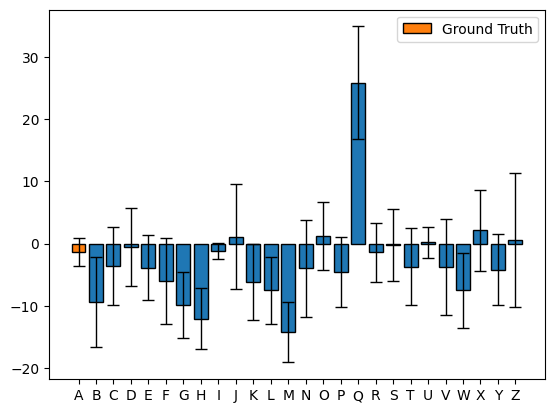

In [ ]:
color = ["C1" if c == adv_letter else "C0" for c in list(ascii_uppercase)]

# Customize the error bar appearance
error_kw = dict(lw=1., capsize=4, capthick=1, ecolor='black')

#plt.title(f"Logit attribution of H{layer}.{head} on adversarial samples with letter {adv_letter}")
bars = plt.bar(x=list(ascii_uppercase), height=avg_output.detach().cpu(), yerr=std_output.detach().cpu(),
        edgecolor="black", color=color, error_kw=error_kw)
# Create a legend indicating the "Ground Truth" bar

plt.legend([bars[ascii_uppercase.index(adv_letter)]], ["Ground Truth"])
plt.savefig("/content/drive/MyDrive/FACT/logitatt.svg")
plt.show()